In [1]:
#Stefans document
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.optimize as sp
import scipy.constants as const
plt.rcParams['figure.dpi'] = 150
%matplotlib inline
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=14, top=True, direction="in")
plt.rc("ytick", labelsize=14, right=True, direction="in")
plt.rc("axes", titlesize=14)
plt.rc("legend", fontsize=14, loc="upper left")

cm = 1.5/2.54 #define ratio for cm and inches

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
Data_names = []

# Method for going through all the data we have, and it fucking works dawg
for (dir_path, dir_names, file_names) in os.walk('./Data_Labday_1'):
    for file_name in file_names:
        if file_name.endswith('.txt'): #ensures we grab only the files ending with .txt
            Data_names.append(os.path.join(dir_path, file_name))

In [3]:
time = [] #array for all time data lists
V1 = [] #Same again for votlage readings

for Data_name in Data_names:
    Data = np.loadtxt(Data_name, skiprows=3)
    time.append(np.linspace(0, 10, len(Data[:, 0])))
    V1.append(Data[:, 1])  # Assuming V1 is in the first column
    #print(time)
    #print(V1)

In [4]:
#Here we make the functions for the fits used
#Guesses for the linear function
a_lin_guess = 0.6 
n_lin_guess = 21e-7
offset_lin_guess = 0.4
p0_lin = [a_lin_guess, n_lin_guess, offset_lin_guess]

l = 0.065 #cm length of weird tube we compress the air in
freq_constant = (2*np.pi)/(633e-9)*l

#Linear fit function hoping that it works on a linear fit
def Linear_fit(t, *p): 
    amplitude = p[0]
    n = p[1]
    offset = p[2]
    return amplitude *(np.cos(freq_constant*2*(n-1)*t)) + offset

#Guesses for the quadratic fit
a_quad_guess = 0.7
n_quad_guess = 21e-7
offset_quad_guess = 0.4
m_quad_guess = 0
p0_Quad = [a_quad_guess, n_quad_guess, offset_quad_guess, m_quad_guess]

#Quadratic fit function if it works like this
def Quad_fit(t, *p): 
    amplitude = p[0]
    n = p[1]
    offset = p[2]
    m = p[3]
    return amplitude *(np.cos(freq_constant*2*((n-1)*t**2+m*t))) + offset

Linear Parameters:
Amplitude: -0.0018544862741686967 $\pm$ 0.00513746754317729
n: 2.482773132016447e-06 $\pm$ 3.668164743440127e-07
Offset: 14.117499036446045 $\pm$ 0.0036327387310375533

Quadratic Parameters:
Amplitude: -0.06066794355582168 +/- [0]
n: 2.123419874362827e-06 +/- 2.2354109776411026e-09
Offset: 14.117698346713851 +/- 0.0036328719306234973
m: 6.154872126806937e-08 +/- 1.3546128689743165e-08


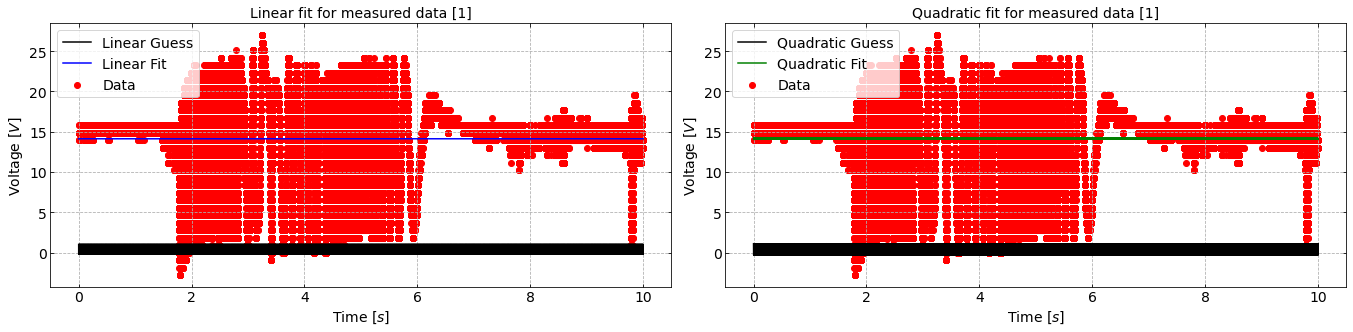

Linear Parameters:
Amplitude: -0.002050558683903842 $\pm$ 0.005208307814878459
n: 1.9943914687892237e-06 $\pm$ 3.5168787211632876e-07
Offset: 14.399649982625585 $\pm$ 0.003682847819720073

Quadratic Parameters:
Amplitude: -0.025953633835470648 +/- [0]
n: 2.10196506092905e-06 +/- 4.2107240483466125e-09
Offset: 14.399731685396713 +/- 0.00368297960453658
m: 3.3444182231048165e-08 +/- 1.9173754286385378e-08


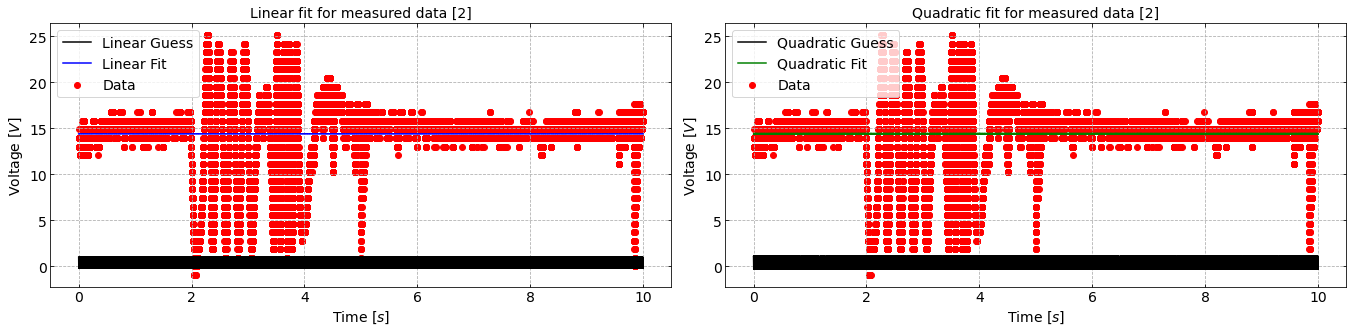

Linear Parameters:
Amplitude: 0.002408154200033019 $\pm$ 0.005320364021143636
n: 1.9804688736138973e-06 $\pm$ 2.9755566090517943e-07
Offset: 14.007535580893062 $\pm$ 0.003762057923063669

Quadratic Parameters:
Amplitude: 0.031351579242484336 +/- [0]
n: 2.088054484046477e-06 +/- 3.1161034672903896e-09
Offset: 14.007357801009876 +/- 0.003762206751198211
m: -1.1426990737734063e-08 +/- 8.296854330113128e-09


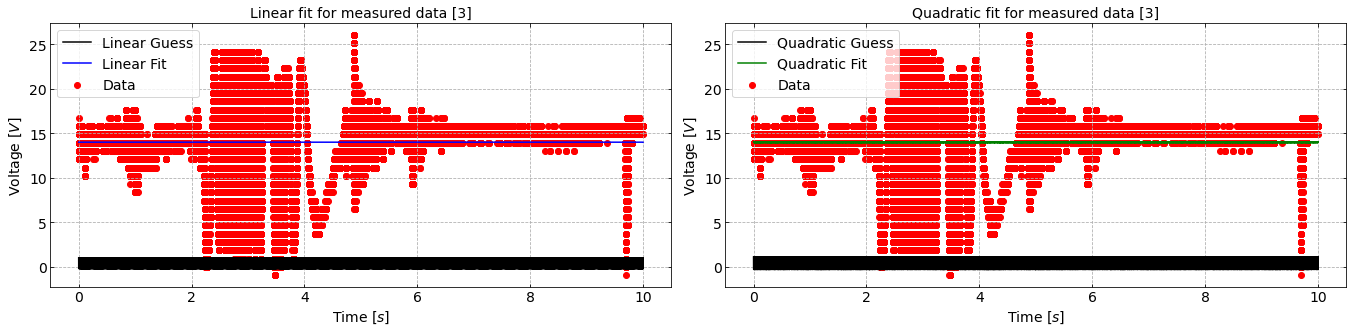

Linear Parameters:
Amplitude: 0.0005807281040786528 $\pm$ 0.0048804715643214576
n: 2.186986495169043e-06 $\pm$ 1.119050752559333e-06
Offset: 11.97847198155553 $\pm$ 0.0034509851977215186

Quadratic Parameters:
Amplitude: 0.0543541741842983 +/- [0]
n: 2.2742281419864733e-06 +/- 6.00011908713112e-09
Offset: 11.978474211358364 +/- 0.003451057502341516
m: -7.33835790857761e-07 +/- 4.6358757839339245e-08


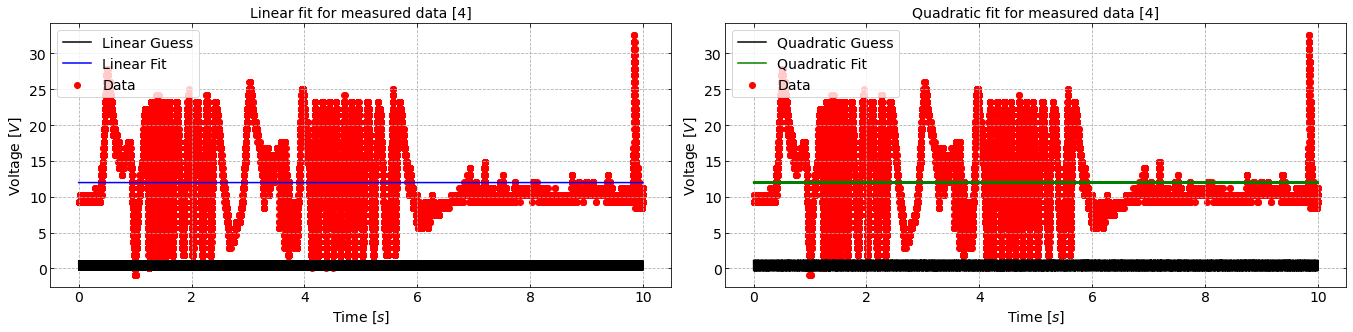

Linear Parameters:
Amplitude: 0.0039132213375683966 $\pm$ 0.00465845034375097
n: 2.19683477759959e-06 $\pm$ 1.625075282176109e-07
Offset: 13.72190294660756 $\pm$ 0.0032940392242670736

Quadratic Parameters:
Amplitude: -0.06905046718978321 +/- [0]
n: 2.127353179772353e-06 +/- 1.2210846980797398e-09
Offset: 13.72172034772092 +/- 0.0032941302868585336
m: -9.48441890270707e-09 +/- 2.9386987239216173e-09


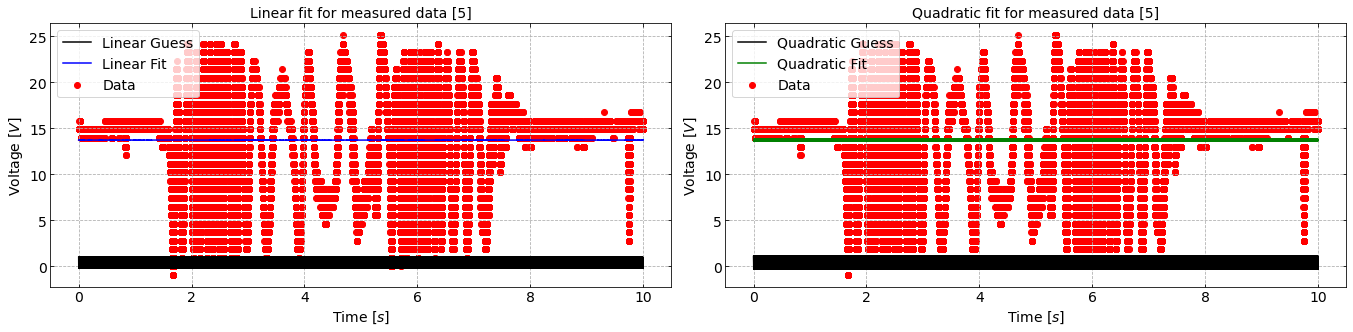

Linear Parameters:
Amplitude: 0.001380505493331956 $\pm$ 0.004558280447770463
n: 2.0900390462013332e-06 $\pm$ 4.4201384876101316e-07
Offset: 13.649128815424206 $\pm$ 0.003223191383391669

Quadratic Parameters:
Amplitude: -0.031406510527240944 +/- [0]
n: 2.1156369769672832e-06 +/- 2.55133150348567e-09
Offset: 13.649058214799046 +/- 0.0032232041146175775
m: -3.3096026076771255e-09 +/- 3.680286448091775e-09


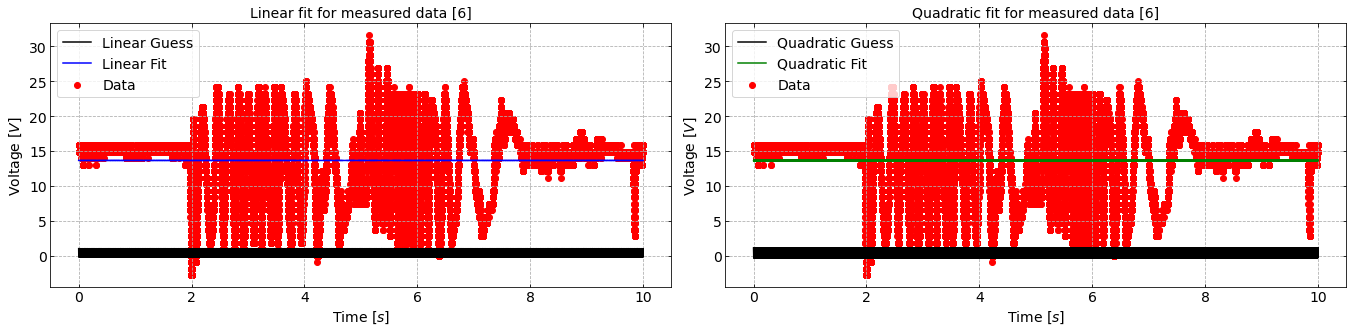

Linear Parameters:
Amplitude: 0.0009931536266515328 $\pm$ 0.0032090452069173867
n: 2.1000008917056265e-06 $\pm$ 4.347845824567762e-07
Offset: 13.530238587927508 $\pm$ 0.0022691435364346423

Quadratic Parameters:
Amplitude: 0.02369264588599017 +/- [0]
n: 1.997422713933694e-06 +/- 9.335735684934854e-09
Offset: 13.53026048597719 +/- 0.0022691537002199067
m: 1.8061579307716729e-06 +/- 7.221629814327442e-08


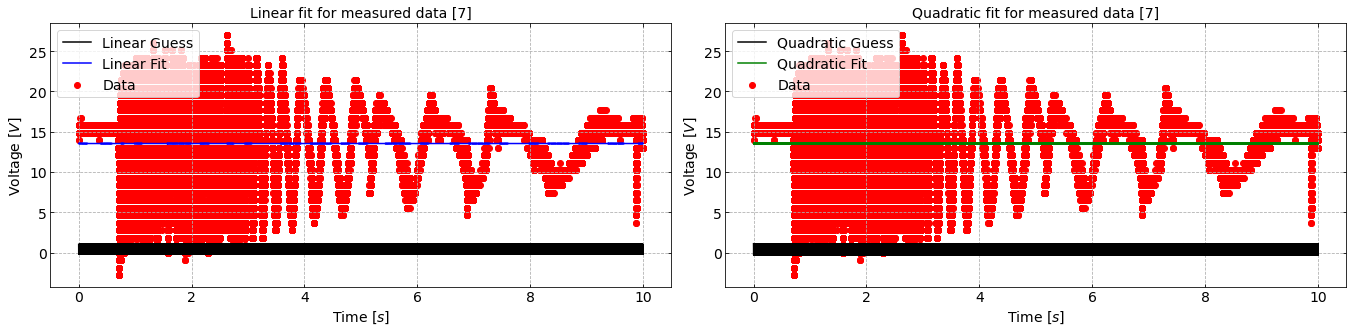

Linear Parameters:
Amplitude: -0.0027089801444628546 $\pm$ 0.004145337099348196
n: 2.1259691279323452e-06 $\pm$ 2.046349858979179e-07
Offset: 13.867344784033072 $\pm$ 0.0029312030014581243

Quadratic Parameters:
Amplitude: 0.04965644018604462 +/- [0]
n: 2.010166495715312e-06 +/- 5.590907641550949e-09
Offset: 13.86736722438784 +/- 0.002931270373649114
m: 7.26957312365169e-07 +/- 4.319004469453209e-08


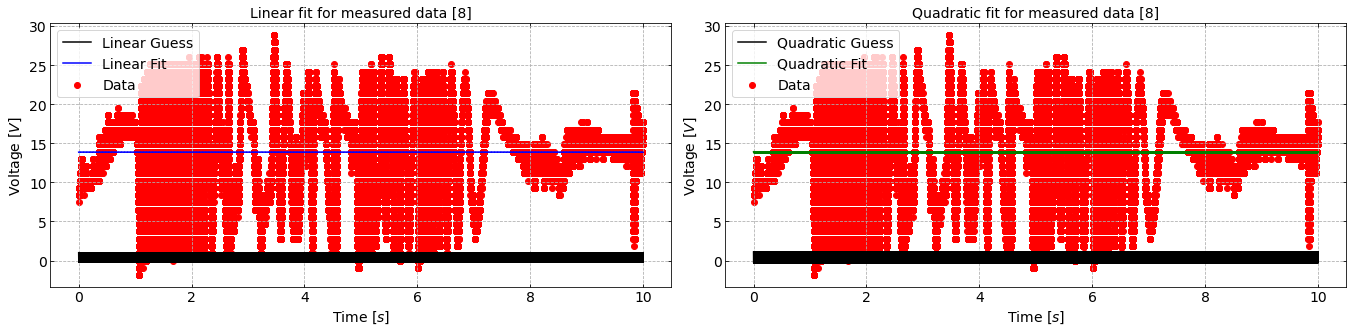

Linear Parameters:
Amplitude: -0.0012753979424956388 $\pm$ 0.003926856629428399
n: 2.1453868764913842e-06 $\pm$ 4.115490843968889e-07
Offset: 12.72664315118509 $\pm$ 0.0027767067218972415

Quadratic Parameters:
Amplitude: 0.03098365084056449 +/- [0]
n: 2.0820988284489655e-06 +/- 6.832711119959475e-09
Offset: 12.726661256574955 +/- 0.0027767177361722934
m: 2.208632583541229e-07 +/- 5.168101647646506e-08


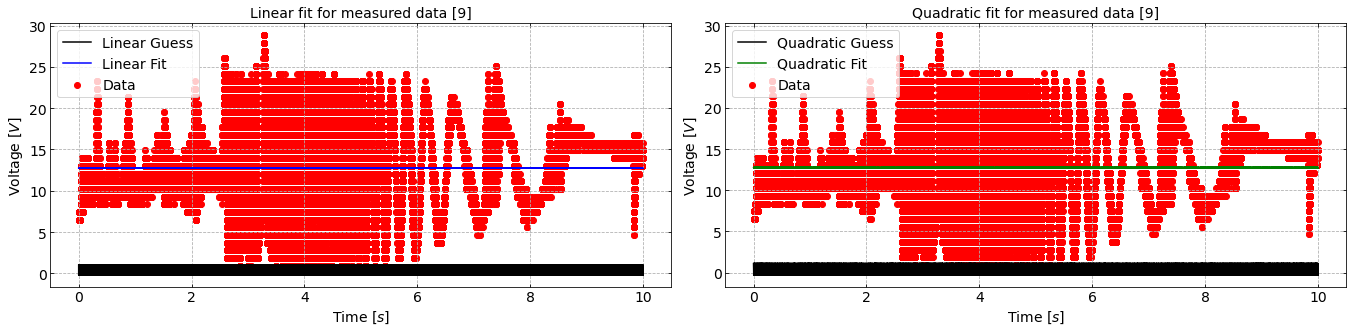

Linear Parameters:
Amplitude: -0.0003364273295297235 $\pm$ 0.003382975211110676
n: 1.9577725383795964e-06 $\pm$ 1.35215623382978e-06
Offset: 13.97086173819969 $\pm$ 0.0023921254511251916

Quadratic Parameters:
Amplitude: -0.033282937794078066 +/- [0]
n: 2.0955623734511802e-06 +/- 2.353750524373001e-09
Offset: 13.970888555334923 +/- 0.0023921670703185823
m: -4.6335414446023294e-08 +/- 1.2552748141325008e-08


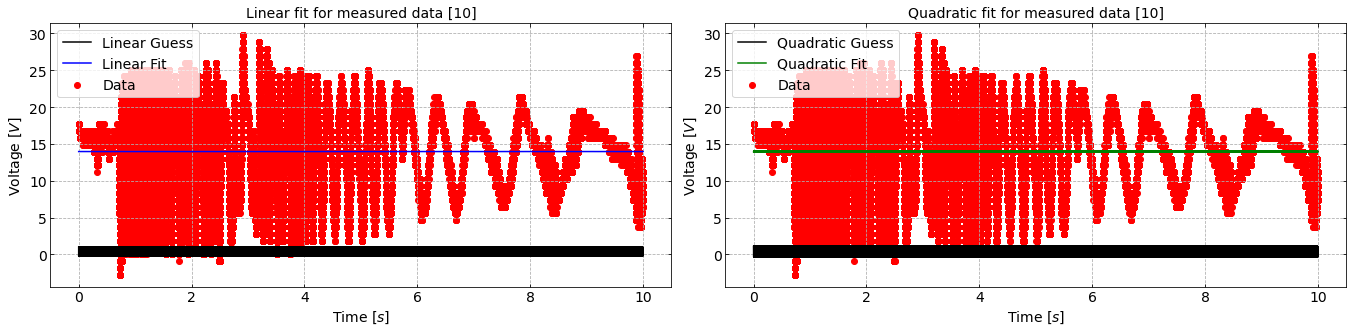

Linear Parameters:
Amplitude: -0.00026039674114398145 $\pm$ 0.00322610503776456
n: 2.2057308442582773e-06 $\pm$ 1.608927434227958e-06
Offset: 13.210759676220794 $\pm$ 0.002281203261415051

Quadratic Parameters:
Amplitude: 0.020621832984590957 +/- [0]
n: 2.1008073607008705e-06 +/- 3.3064804803372184e-09
Offset: 13.210739668696704 +/- 0.0022812216940446503
m: -3.40974514507713e-08 +/- 1.5159306772505164e-08


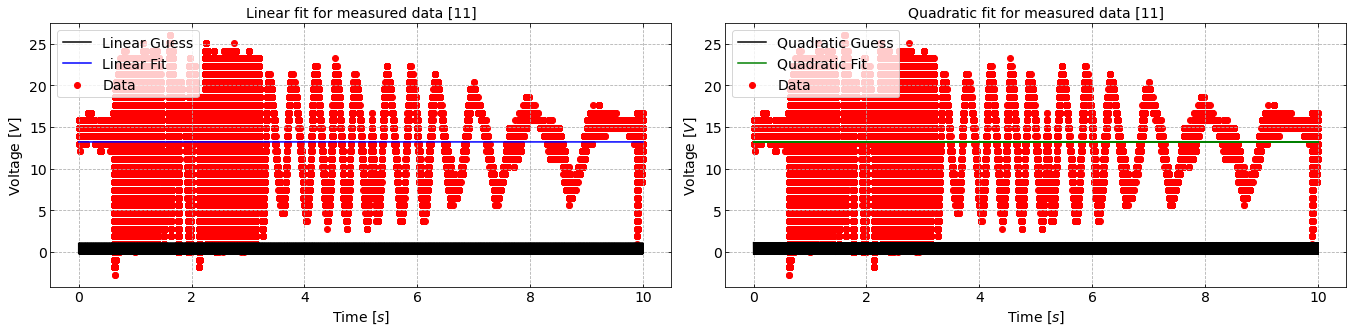

Linear Parameters:
Amplitude: 0.0009463423110645367 $\pm$ 0.003261035376279563
n: 2.447672934116783e-06 $\pm$ 1.0783253038206147e-06
Offset: 14.004520753375866 $\pm$ 0.0023059110315107544

Quadratic Parameters:
Amplitude: 0.008687232401497623 +/- [0]
n: 2.099668015727236e-06 +/- 7.601379420978968e-09
Offset: 14.00453094122442 +/- 0.00230592188122226
m: 2.7675386137423114e-08 +/- 3.104533770601929e-08


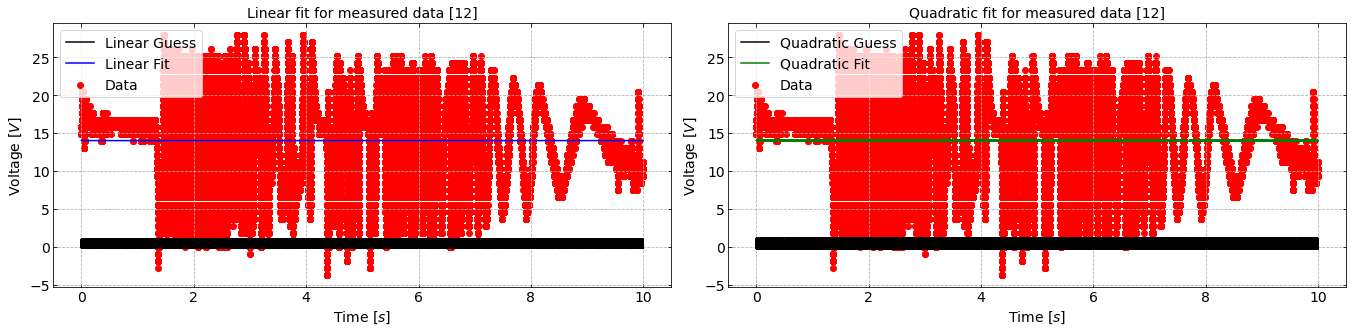

Linear Parameters:
Amplitude: 0.00031418840385610824 $\pm$ 0.004239671578771591
n: 2.099932897274911e-06 $\pm$ 1.80519627533963e-06
Offset: 13.785385587379896 $\pm$ 0.0029978842359659045

Quadratic Parameters:
Amplitude: 0.048399227743776696 +/- [0]
n: 2.1195467904450064e-06 +/- 5.752529649914184e-09
Offset: 13.78544332159956 +/- 0.0029979143237028978
m: -5.710106709841228e-07 +/- 4.4509940816161574e-08


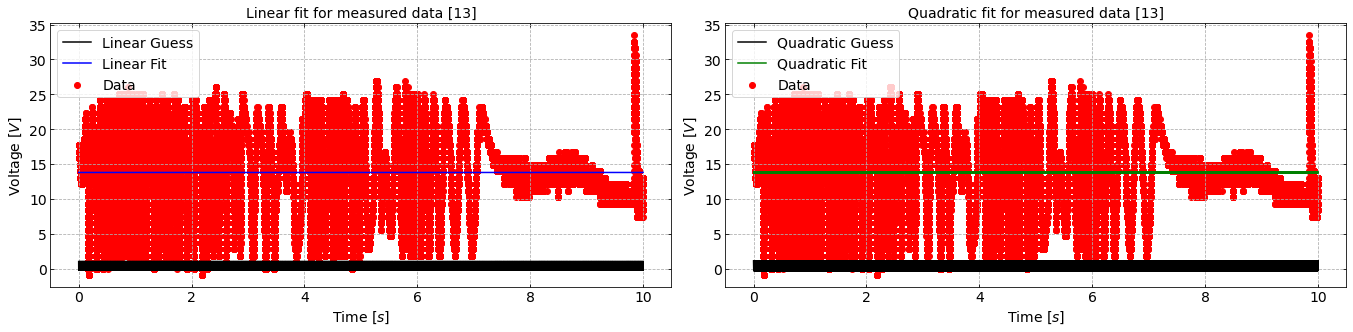

In [5]:
#Here using subplots to get 6 graphs for each iteration together.

lin_const = []
lin_sigma = []
quad_const =[]
quad_sigma =[]

fig, axes = plt.subplots(1,2, figsize=(32*cm,8*cm)) #figure done in inches, use this to choose a good scale
axes = axes.flatten() #Means we can iterate over it

#Here is my loop where i plot for curve fits with different powers.
for i in range(len(time)):
    # Linear fit
    axes[0].cla()  # Clear the first subplot
    plt.sca(axes[0])  # Set current axis to the first subplot
    popt_1, pcov_1 = sp.curve_fit(Linear_fit, time[i], V1[i], p0=p0_lin, absolute_sigma=True)
    # Calculate the standard deviations of the fitted parameters
    lin_err = np.sqrt(np.diag(pcov_1))
    plt.title(f'Linear fit for measured data {[i+1]}')
    plt.plot(time[i], Linear_fit(time[i], *p0_lin), label='Linear Guess', color='black')  # Plot linear fit
    plt.plot(time[i], Linear_fit(time[i], *popt_1), label='Linear Fit', color='blue')  # Plot linear fit
    plt.scatter(time[i], V1[i], label='Data', color='red')  # Plot data points
    plt.xlabel('Time [$s$]')
    plt.ylabel('Voltage [$V$]')
    plt.grid(ls = '--')
    plt.legend()

    # Quadratic fit
    axes[1].cla()  # Clear the first subplot
    plt.sca(axes[1])  # Set current axis to the second subplot
    popt_2, pcov_2 = sp.curve_fit(Quad_fit, time[i], V1[i], p0=p0_Quad, absolute_sigma=True)
    #calc standard deviation of the fitted parameters
    quad_err = np.sqrt(np.diag(pcov_2))
    plt.title(f'Quadratic fit for measured data {[i+1]}')
    plt.plot(time[i], Quad_fit(time[i], *p0_Quad), label='Quadratic Guess', color='black')  # Plot quadratic fit
    plt.plot(time[i], Quad_fit(time[i], *popt_2), label='Quadratic Fit', color='green')  # Plot quadratic fit
    plt.scatter(time[i], V1[i], label='Data', color='red')  # Plot data points
    plt.xlabel('Time [$s$]')
    plt.ylabel('Voltage [$V$]')
    plt.legend()
    plt.grid(ls = '--')
    plt.tight_layout()
    
    #Print statements to get the fitted parameters
    print("Linear Parameters:")
    print("Amplitude:", popt_1[0], '$\pm$', lin_err[0])
    print("n:", popt_1[1], '$\pm$', lin_err[1])
    lin_const.append(popt_1[1])
    lin_sigma.append(lin_err[1])
    print("Offset:", popt_1[2], '$\pm$', lin_err[2])
    print()
    print("Quadratic Parameters:")
    print("Amplitude:", popt_2[0], "+/-", [0])
    print("n:", popt_2[1], "+/-", quad_err[1])
    print("Offset:", popt_2[2], "+/-", quad_err[2])
    print("m:", popt_2[3], "+/-", quad_err[3])
    plt.show()